# Exploring the Achievements and History Tables

In [24]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [25]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [26]:
!aws s3 ls s3://ads-508-final/playstation/

                           PRE achievements/
                           PRE games/
                           PRE history/
                           PRE players/
                           PRE prices/
                           PRE purchased_games/


In [27]:
# set path for public bucket
s3_playstation_path_public = 's3://ads-508-final/playstation/'

In [28]:
# set staging directory in private bucket
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [29]:
# create connection with pyathena
# EXPLORE USING ENGINE
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

In [30]:
# define database name
database_name = "playstationaws"

In [62]:
# create database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement) 

CREATE DATABASE IF NOT EXISTS playstationaws


In [63]:
# execute query to create database
pd.read_sql(statement, conn)

""


In [64]:
# execute query to show database is present
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,default
1,playstationaws


## Creating Achievements and History Tables

In [65]:
achievements_create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.achievements (
    achievementid STRING,
    gameid STRING,
    title STRING,
    description STRING,
    rarity STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '{s3_playstation_path_public}'
TBLPROPERTIES ("skip.header.line.count"="1");
"""

print(achievements_create_table_query)


CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.achievements (
    achievementid STRING,
    gameid STRING,
    title STRING,
    description STRING,
    rarity STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://ads-508-final/playstation/'
TBLPROPERTIES ("skip.header.line.count"="1");



In [66]:
# execute query to create table and load data
pd.read_sql(achievements_create_table_query, conn)

""


In [67]:
# define query and check load
statement = """select * from {}.achievements limit 50""".format(database_name)

In [68]:
df_achievements = pd.read_sql(statement, conn)
df_achievements.head(5)

,achievementid,gameid,title,description,rarity
0,749347,10.39,10.39,7.99,1408.0
1,749281,1.49,1.49,1.19,220.0
2,749839,14.99,14.99,11.99,2310.0
3,749280,1.49,1.49,1.19,220.0
4,749375,0.99,0.49,0.39,165.0


In [69]:
# Create the "history" table
history_create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.history (
    playerid STRING,
    achievementid STRING,
    date_acquired DATE
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '{s3_playstation_path_public}'
TBLPROPERTIES ("skip.header.line.count"="1");
"""

print(history_create_table_query)


CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.history (
    playerid STRING,
    achievementid STRING,
    date_acquired DATE
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://ads-508-final/playstation/'
TBLPROPERTIES ("skip.header.line.count"="1");



In [70]:
# execute query to create table and load data
pd.read_sql(history_create_table_query, conn)

""


In [71]:
# define query and check load
statement_2 = """select * from {}.history limit 50""".format(database_name)

In [72]:
df_history = pd.read_sql(statement_2, conn)
df_history.head(5)

,playerid,achievementid,date_acquired
0,749375,Medieval Match Master,None
1,749839,Sunforge Solar Survival,None
2,749347,Find Love Or Die Trying,None
3,749341,Medieval Match Master,None
4,749097,Bust A Block 2,None


## EDA on Achievements and History Tables

In [73]:
# 1. Check for missing values
missing_values_achievements = df_achievements.isnull().sum()
missing_values_history = df_history.isnull().sum()

# 2. Check for duplicates
duplicates_achievements = df_achievements.duplicated().sum()
duplicates_history = df_history.duplicated().sum()

# 3. Summary statistics for numerical columns
summary_achievements = df_achievements.describe()
summary_history = df_history.describe()

# 4. Column data types
data_types_achievements = df_achievements.dtypes
data_types_history = df_history.dtypes


In [74]:
# Format Missing Values in df_achievements and df_history
missing_values_achievements = df_achievements.isnull().sum().reset_index()
missing_values_achievements.columns = ['Column', 'Missing Values']
missing_values_achievements = missing_values_achievements[missing_values_achievements['Missing Values'] > 0]

missing_values_history = df_history.isnull().sum().reset_index()
missing_values_history.columns = ['Column', 'Missing Values']
missing_values_history = missing_values_history[missing_values_history['Missing Values'] > 0]

# Format Duplicates in df_achievements and df_history
duplicates_achievements = df_achievements.duplicated().sum()
duplicates_history = df_history.duplicated().sum()

# Get summary statistics for df_achievements and df_history
summary_achievements = df_achievements.describe().transpose()
summary_history = df_history.describe().transpose()

# Data Type Information
data_types_achievements = pd.DataFrame(df_achievements.dtypes, columns=['Data Type'])
data_types_history = pd.DataFrame(df_history.dtypes, columns=['Data Type'])

# Display the formatted results
print("=== Missing Values in Achievements Dataset ===")
print(missing_values_achievements.to_string(index=False))

print("\n=== Missing Values in History Dataset ===")
print(missing_values_history.to_string(index=False))

print(f"\n=== Duplicates in Achievements Dataset: {duplicates_achievements} ===")
print(f"=== Duplicates in History Dataset: {duplicates_history} ===")

# Print Summary Statistics
print("\n=== Summary Statistics for Achievements Dataset ===")
print(summary_achievements)

print("\n=== Summary Statistics for History Dataset ===")
print(summary_history)

print("\n=== Data Types for Achievements Dataset ===")
print(data_types_achievements)

print("\n=== Data Types for History Dataset ===")
print(data_types_history)

=== Missing Values in Achievements Dataset ===
Empty DataFrame
Columns: [Column, Missing Values]
Index: []

=== Missing Values in History Dataset ===
       Column  Missing Values
date_acquired              50

=== Duplicates in Achievements Dataset: 0 ===
=== Duplicates in History Dataset: 0 ===

=== Summary Statistics for Achievements Dataset ===
              count unique     top freq
achievementid    50     50  749347    1
gameid           50     21    1.49    8
title            50     20    1.49    8
description      50     22    1.19    8
rarity           50     17            9

=== Summary Statistics for History Dataset ===
              count unique                   top freq
playerid         50     50                749375    1
achievementid    50     37  GGmuks Casino: Slots    4
date_acquired     0      0                   NaN  NaN

=== Data Types for Achievements Dataset ===
              Data Type
achievementid    object
gameid           object
title            object
desc

## Visualizing the Achievements Table (Rarity Column)

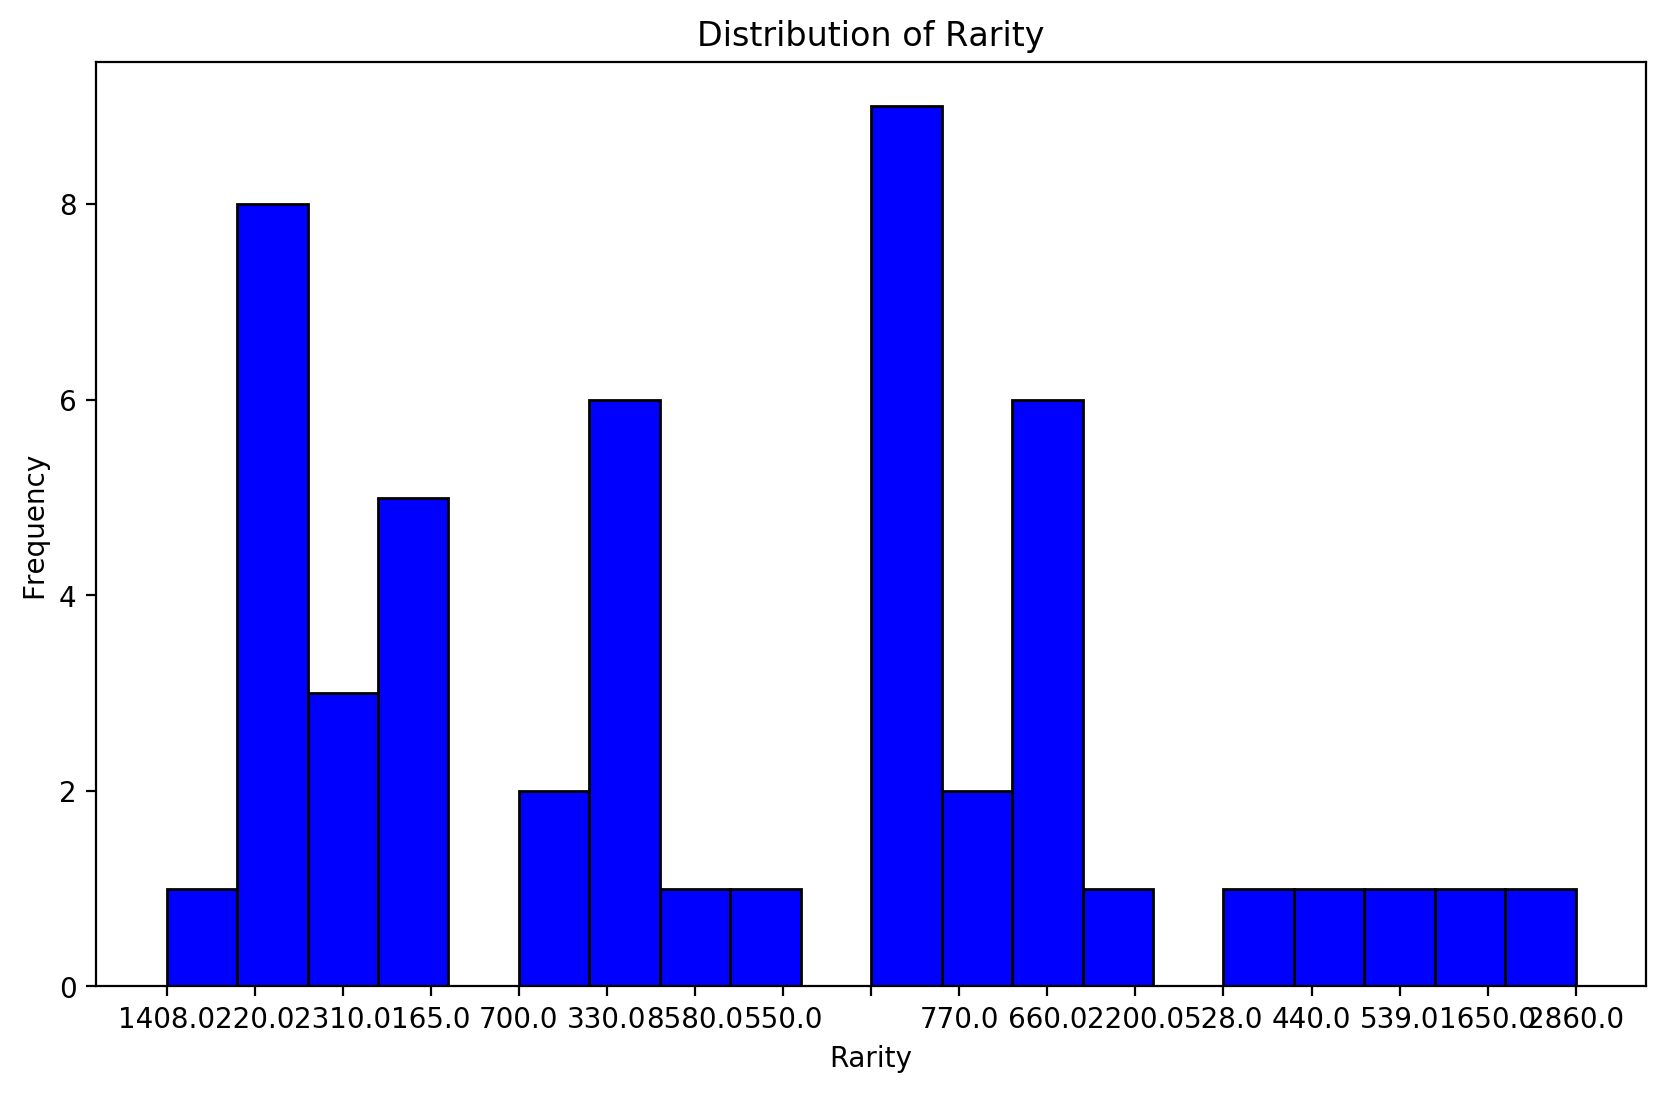

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(df_achievements['rarity'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Rarity')
plt.xlabel('Rarity')
plt.ylabel('Frequency')
plt.show()

## Visualizing the History Table (Distribution of Achievement IDs)

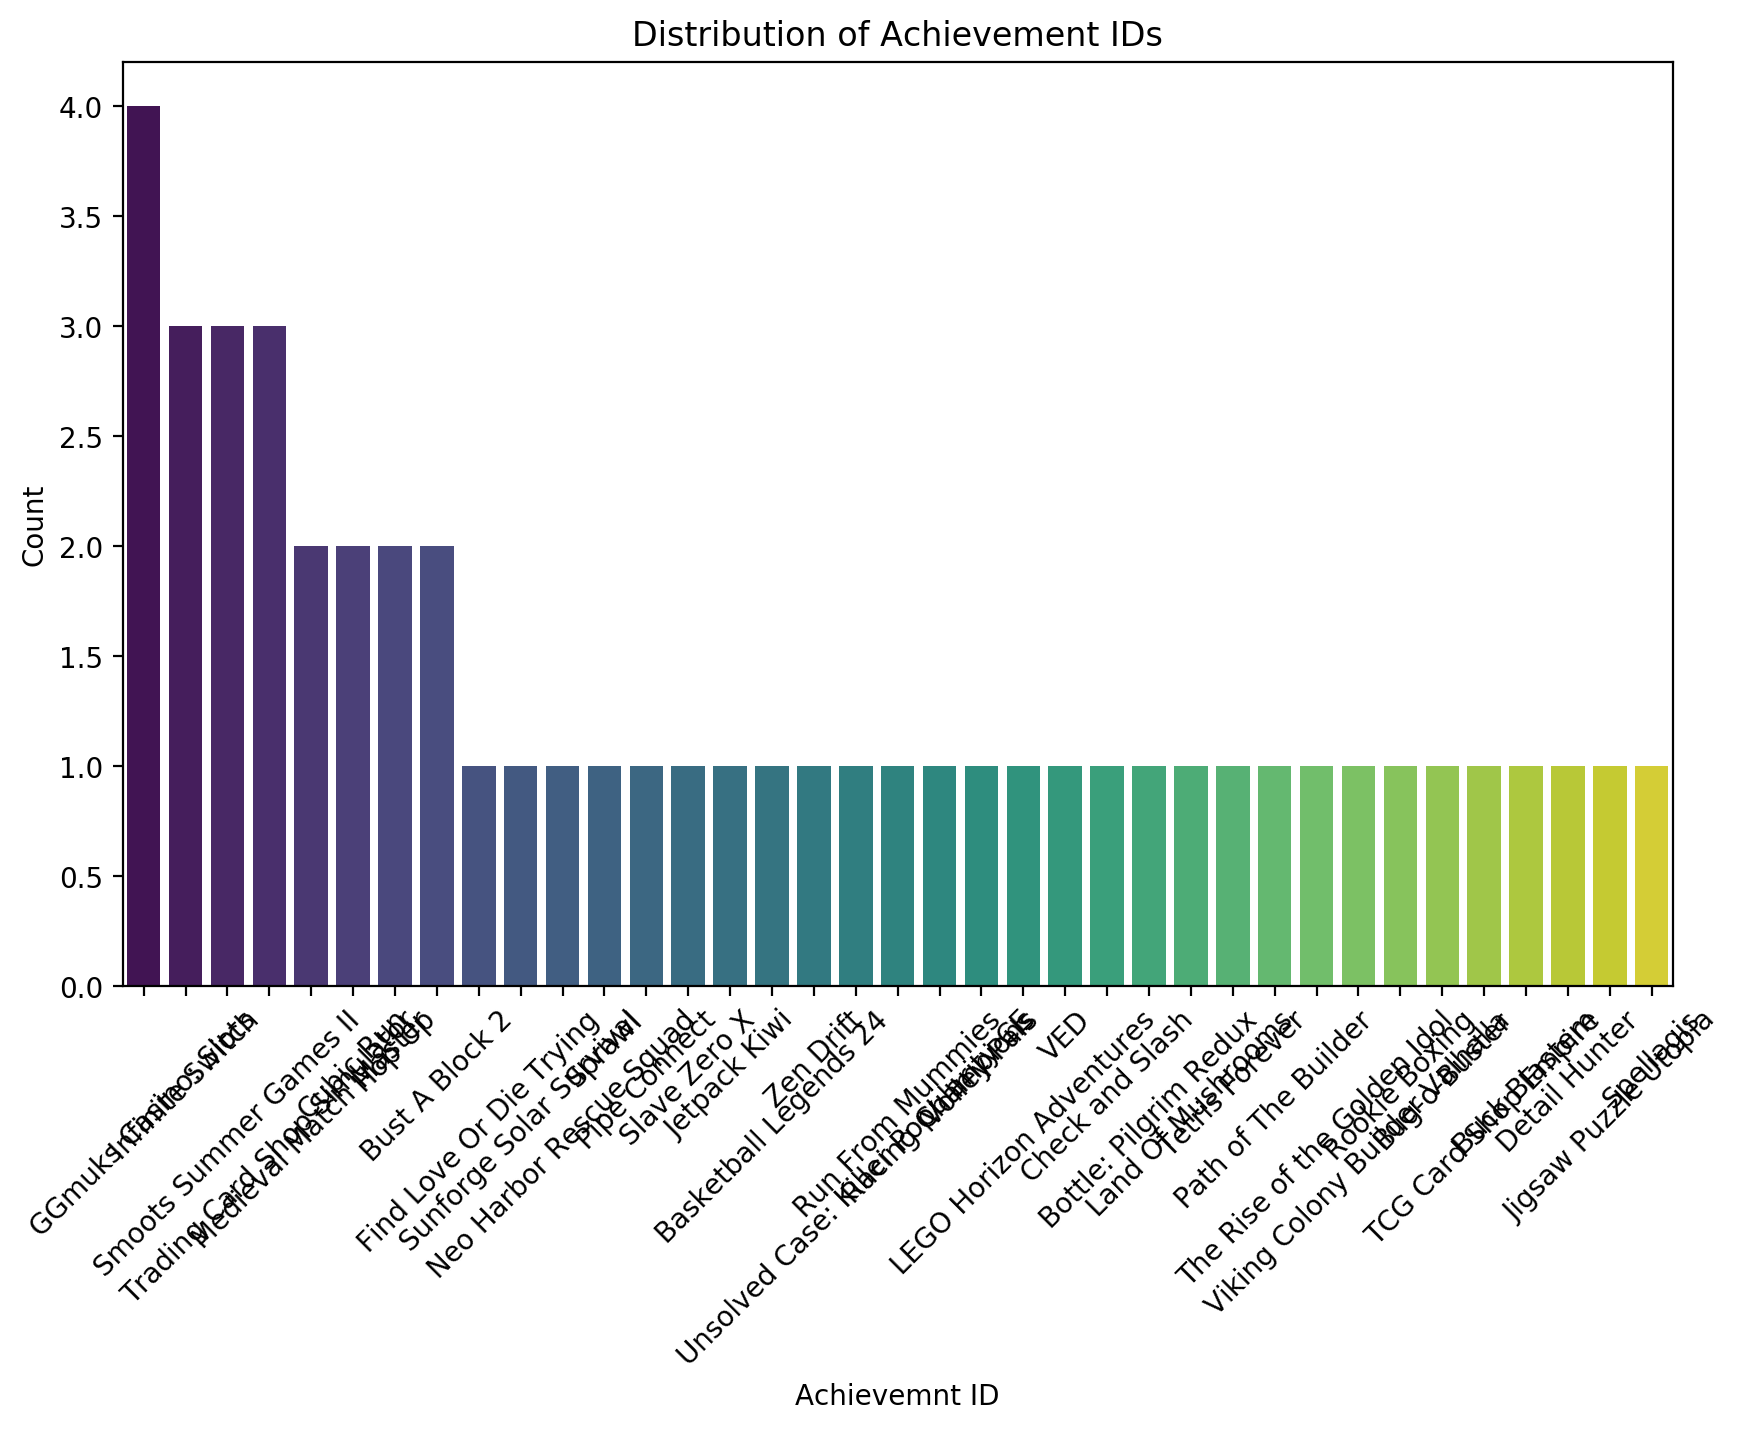

In [76]:
achievementid_counts = df_history['achievementid'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(x='achievementid', data=df_history, order=achievementid_counts.index, palette='viridis')
plt.title('Distribution of Achievement IDs')
plt.xlabel('Achievemnt ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()